In [319]:
"""
Imports and Dependencies Used in This Project:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, precision_recall_curve, auc
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

Downloads:
nltk.download('punkt')
nltk.download('stopwords')
pip install wordcloud
"""


"\nImports and Dependencies Used in This Project:\nimport pandas as pd\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nimport nltk\nimport re\nimport string\n\nfrom nltk.corpus import stopwords\nfrom nltk.stem.porter import PorterStemmer\n\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.preprocessing import LabelEncoder\nfrom sklearn.feature_extraction.text import TfidfVectorizer\nfrom sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, precision_recall_curve, auc\nfrom sklearn.naive_bayes import MultinomialNB\nfrom sklearn.svm import SVC\n\nDownloads:\nnltk.download('punkt')\nnltk.download('stopwords')\npip install wordcloud\n"

In [320]:
import pandas as pd
import matplotlib.pyplot as plt

Load and Prepare Dataset

In [321]:


# Load dataset
df = pd.read_csv("spam.csv", encoding="latin-1")
# Select relevant columns
df = df[['v1', 'v2']]
# Rename columns for clarity
df.rename(columns={'v1': 'target', 'v2': 'text'}, inplace=True)





In [322]:
# Display first few rows of the dataset and target distribution
print(df.head())
print(df['target'].value_counts())

  target                                               text
0    ham  Go until jurong point, crazy.. Available only ...
1    ham                      Ok lar... Joking wif u oni...
2   spam  Free entry in 2 a wkly comp to win FA Cup fina...
3    ham  U dun say so early hor... U c already then say...
4    ham  Nah I don't think he goes to usf, he lives aro...
target
ham     4825
spam     747
Name: count, dtype: int64


**1. Data Cleaning**

In [323]:
# Remove duplicate messages
df=df.drop_duplicates(keep='first')

In [324]:
# Check dataset size after cleaning
df.shape

(5169, 2)

In [325]:
# Encode labels: spam = 1, ham = 0
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['target'] = encoder.fit_transform(df['target'])

In [326]:
#get info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5169 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  5169 non-null   int32 
 1   text    5169 non-null   object
dtypes: int32(1), object(1)
memory usage: 101.0+ KB


In [327]:
df.isnull().sum()

target    0
text      0
dtype: int64

In [328]:
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


**2. EDA**

In [329]:
df.target.value_counts()

target
0    4516
1     653
Name: count, dtype: int64

<Axes: ylabel='target'>

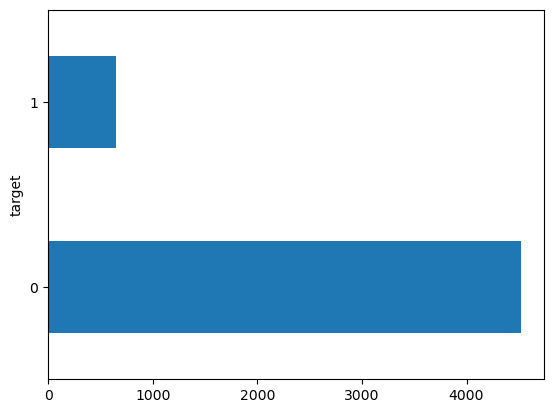

In [330]:
# Plot class distribution
df.target.value_counts().plot.barh()

In [331]:
import nltk

In [332]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [333]:
# Number of characters
df['num_char']=df['text'].apply(len)

In [334]:
# Number of words
df['num_words']=df['text'].apply(lambda x:len(nltk.word_tokenize(x)))

In [335]:
# Number of sentences
df['num_sent']=df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [336]:
df.head()

,target,text,num_char,num_words,num_sent
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [337]:
#ham
df[df['target']==0][['num_char','num_words','num_sent']].describe()

,num_char,num_words,num_sent
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [338]:
#spam
df[df['target']==1][['num_char','num_words','num_sent']].describe()

,num_char,num_words,num_sent
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


In [339]:
import seaborn as sns

<Axes: xlabel='num_char', ylabel='Count'>

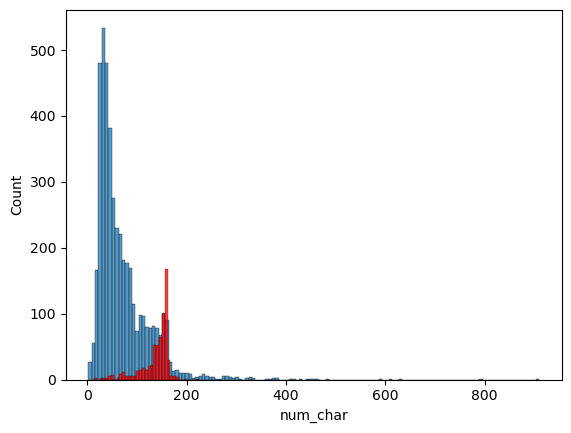

In [340]:
#plot histogram for num_char
sns.histplot(df[df['target']==0]['num_char'])
sns.histplot(df[df['target']==1]['num_char'],color='red')

<Axes: xlabel='num_words', ylabel='Count'>

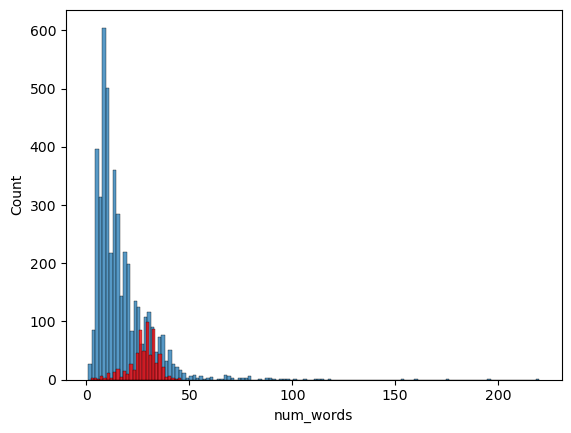

In [341]:
#plot histogram for num_words   
sns.histplot(df[df['target']==0]['num_words'])
sns.histplot(df[df['target']==1]['num_words'],color='red')

<Axes: xlabel='num_sent', ylabel='Count'>

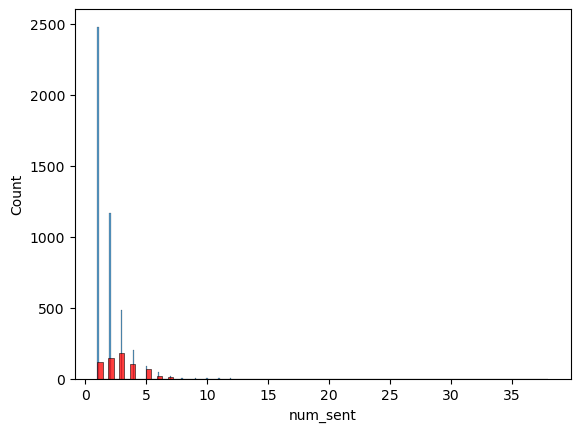

In [342]:
#plot histogram for num_sent
sns.histplot(df[df['target']==0]['num_sent'])
sns.histplot(df[df['target']==1]['num_sent'],color='red')

<Axes: >

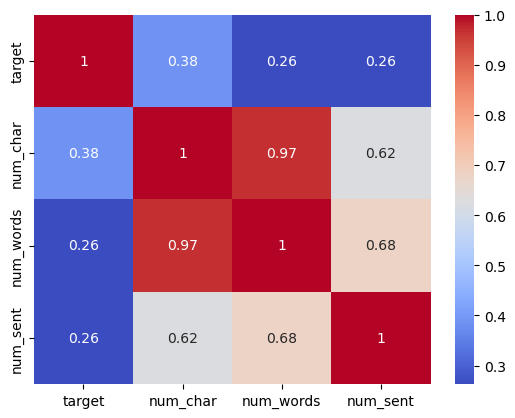

In [343]:
#Heatmap
sns.heatmap(df[['target','num_char','num_words','num_sent']].corr(),annot=True,cmap='coolwarm')

**3. Text Preprocessing**

In [344]:
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
import re
def text_transform(text):
    #lowercase
    text=text.lower()
    #tokenization
    text=nltk.word_tokenize(text)
    #removing special characters
    y=[]
    for word in text:
        word=re.sub(r'[^a-zA-Z0-9\s]','',word)
        if word:
            y.append(word)
    text=y[:]
    y.clear()
    #removing stopwords and punctuation
    for word in text:
        if word not in stopwords.words('english') and word not in string.punctuation:
            y.append(word)
    text=y[:]
    y.clear()
    #Stemming
    ps=PorterStemmer()
    for word in text:
        y.append(ps.stem(word))
    
    return " ".join(y)
    

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [345]:
#Apply preprocessing to all SMS messages
df['transformed_text']=df['text'].apply(text_transform)

In [346]:
df.head()

,target,text,num_char,num_words,num_sent,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah nt think goe usf live around though


Wordcloud


In [347]:
from wordcloud import WordCloud
wc=WordCloud(width=1000,height=500,min_font_size=10,background_color='white')

In [348]:
spam_wc=wc.generate(df[df['target']==1]['transformed_text'].str.cat(sep=" "))

(-0.5, 999.5, 499.5, -0.5)

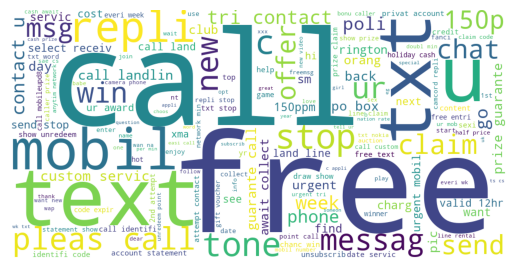

In [349]:
plt.imshow(spam_wc.to_image())
plt.axis("off")


(-0.5, 999.5, 499.5, -0.5)

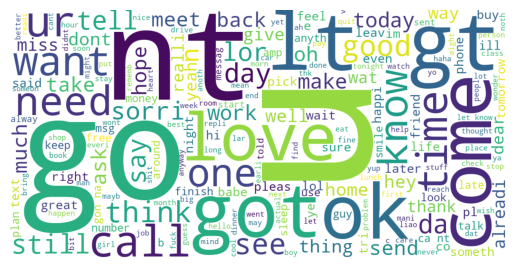

In [350]:
ham_wc=wc.generate(df[df['target']==0]['transformed_text'].str.cat(sep=" "))
plt.imshow(ham_wc.to_image())
plt.axis("off")

**Feature Extraction and Modeling**

In [351]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

Train–Test Split

In [352]:
X_train, X_test, y_train, y_test = train_test_split(
    df['transformed_text'], 
    df['target'], 
    test_size=0.2, 
    random_state=42, 
    stratify=df['target']
)

In [353]:
#TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=3000)
# Transform text into numerical features
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()

**Support Vector Machine**

In [354]:
# Initialize SVC model
svm_model = SVC(kernel='sigmoid', gamma=1.0, class_weight='balanced')
# Train the model
svm_model.fit(X_train_tfidf, y_train)

SVC(class_weight='balanced', gamma=1.0, kernel='sigmoid')

In [355]:
# Predictions on training data
y_train_pred = svm_model.predict(X_train_tfidf)

In [356]:
# Predictions on test data
y_test_pred = svm_model.predict(X_test_tfidf)

In [357]:
# ---- Training Performance ----
print("SVM Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("\nSVM Training Classification Report:\n")
print(classification_report(y_train, y_train_pred))


SVM Training Accuracy: 0.9852478839177751

SVM Training Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      3613
           1       0.90      0.99      0.94       522

    accuracy                           0.99      4135
   macro avg       0.95      0.99      0.97      4135
weighted avg       0.99      0.99      0.99      4135



In [358]:
# ---- Testing Performance ----
print("SVM Testing Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nSVM Testing Classification Report:\n")
print(classification_report(y_test, y_test_pred))

SVM Testing Accuracy: 0.9671179883945842

SVM Testing Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       903
           1       0.85      0.90      0.87       131

    accuracy                           0.97      1034
   macro avg       0.92      0.94      0.93      1034
weighted avg       0.97      0.97      0.97      1034



Confusion matrix

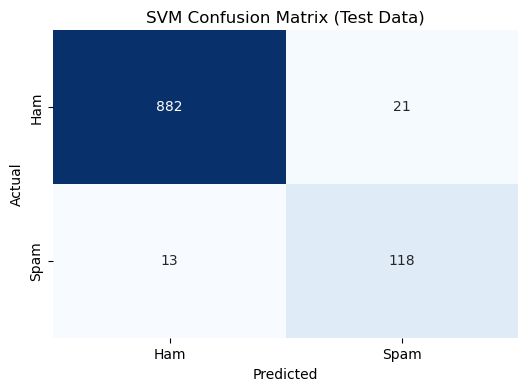

In [359]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('SVM Confusion Matrix (Test Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Ham', 'Spam'])
plt.yticks([0.5, 1.5], ['Ham', 'Spam'])
plt.show()

**Multinomial Naive Bayes**

In [360]:
from sklearn.naive_bayes import MultinomialNB


In [361]:
# Train Naive Bayes model
mnb = MultinomialNB()
mnb.fit(X_train_tfidf, y_train)

MultinomialNB()

In [362]:
# Predictions on training data
y_train_pred = mnb.predict(X_train_tfidf)

In [363]:
# Predictions on test data
y_test_pred = mnb.predict(X_test_tfidf)


In [364]:
# ---- Training Performance ----
print("Naive Bayes Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("\nNaive Bayes Training Classification Report:\n")
print(classification_report(y_train, y_train_pred))

Naive Bayes Training Accuracy: 0.9813784764207981

Naive Bayes Training Classification Report:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3613
           1       1.00      0.85      0.92       522

    accuracy                           0.98      4135
   macro avg       0.99      0.93      0.95      4135
weighted avg       0.98      0.98      0.98      4135



In [365]:
# ---- Testing Performance ----
print("Naive Bayes Testing Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nNaive Bayes Testing Classification Report:\n")
print(classification_report(y_test, y_test_pred))


Naive Bayes Testing Accuracy: 0.971953578336557

Naive Bayes Testing Classification Report:

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       903
           1       0.98      0.79      0.88       131

    accuracy                           0.97      1034
   macro avg       0.98      0.90      0.93      1034
weighted avg       0.97      0.97      0.97      1034



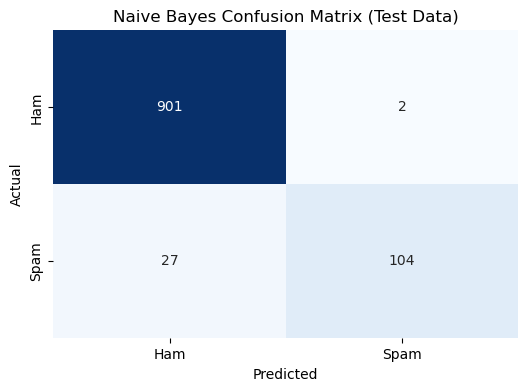

In [366]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Naive Bayes Confusion Matrix (Test Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Ham', 'Spam'])
plt.yticks([0.5, 1.5], ['Ham', 'Spam'])
plt.show()

ROC Curve

In [367]:
# ROC Curve for Naive Bayes and SVC

from sklearn.metrics import roc_curve, auc

In [368]:
# Naive Bayes probabilities
nb_probs = mnb.predict_proba(X_test_tfidf)[:, 1]

In [369]:
# SVC decision scores (since probability=True is not used)
svc_scores = svm_model.decision_function(X_test_tfidf)


In [370]:
# Compute ROC curve and AUC for Naive Bayes
fpr_nb, tpr_nb, _ = roc_curve(y_test, nb_probs)
roc_auc_nb = auc(fpr_nb, tpr_nb)

In [371]:
fpr_svc, tpr_svc, _ = roc_curve(y_test, svc_scores)
roc_auc_svc = auc(fpr_svc, tpr_svc)


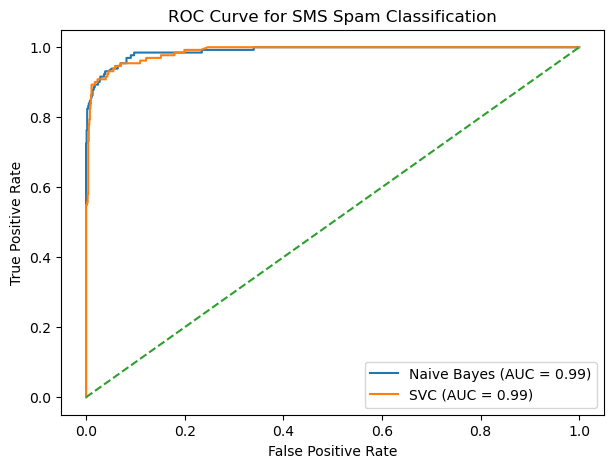

In [372]:
# Plot ROC curves
plt.figure(figsize=(7, 5))
plt.plot(fpr_nb, tpr_nb, label=f"Naive Bayes (AUC = {roc_auc_nb:.2f})")
plt.plot(fpr_svc, tpr_svc, label=f"SVC (AUC = {roc_auc_svc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for SMS Spam Classification")
plt.legend(loc="lower right")
plt.show()

Precision–Recall Curve

In [373]:
from sklearn.metrics import precision_recall_curve, average_precision_score

In [374]:
#Compute Precision–Recall values
precision_nb, recall_nb, _ = precision_recall_curve(y_test, nb_probs)
ap_nb = average_precision_score(y_test, nb_probs)

precision_svc, recall_svc, _ = precision_recall_curve(y_test, svc_scores)
ap_svc = average_precision_score(y_test, svc_scores)


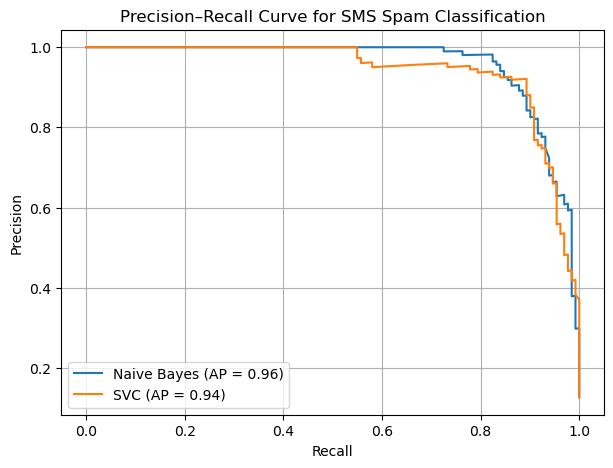

In [375]:
#Plot Precision–Recall Curves
plt.figure(figsize=(7, 5))

plt.plot(recall_nb, precision_nb, label=f"Naive Bayes (AP = {ap_nb:.2f})")
plt.plot(recall_svc, precision_svc, label=f"SVC (AP = {ap_svc:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve for SMS Spam Classification")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()



In [376]:
# Custom SMS Prediction 

custom_sms = [
    "Congratulations! you have won a iphone 14 pro max. Call now to claim your prize.",
    "Hey, are we still meeting for lunch today?",
    "URGENT! You have been selected for a cash reward. Reply YES now!",
    "Can you send me the notes from today's class?"
]


custom_sms_cleaned = [text_transform(msg) for msg in custom_sms]

custom_sms_tfidf = tfidf.transform(custom_sms_cleaned).toarray()

# Predictions
svc_predictions = svm_model.predict(custom_sms_tfidf)
nb_predictions = mnb.predict(custom_sms_tfidf)

# Display predictions 
for i, msg in enumerate(custom_sms):
    print("SMS Message:")
    print(msg)
    print("SVC Prediction:", "Spam" if svc_predictions[i] == 1 else "Ham")
    print("Naive Bayes Prediction:", "Spam" if nb_predictions[i] == 1 else "Ham")
    print("-" * 70)


SMS Message:
Congratulations! you have won a iphone 14 pro max. Call now to claim your prize.
SVC Prediction: Spam
Naive Bayes Prediction: Spam
----------------------------------------------------------------------
SMS Message:
Hey, are we still meeting for lunch today?
SVC Prediction: Ham
Naive Bayes Prediction: Ham
----------------------------------------------------------------------
SMS Message:
URGENT! You have been selected for a cash reward. Reply YES now!
SVC Prediction: Spam
Naive Bayes Prediction: Spam
----------------------------------------------------------------------
SMS Message:
Can you send me the notes from today's class?
SVC Prediction: Ham
Naive Bayes Prediction: Ham
----------------------------------------------------------------------
